##### This requires the DBTL0_Top3 file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re
from adjustText import adjust_text

#### Import Top3 data of interest

Load Top3 data from each of the DBTL cycles for analysis

In [2]:
# Define the filenames and the samples of interest
filenames = [f'DBTL{i}.csv' for i in range(7)]

# Load CSV files and concatenate into a single dataframe
dataframes = [pd.read_csv(filename) for filename in filenames]
combined_df = pd.concat(dataframes, ignore_index=True)

Translate Top3 proteins into locus identities and then transform all of the .csvs

In [3]:
# Load the name_df DataFrame for translation
name_df = pd.read_csv('proteomics_id_translator_240305.csv') 

# Create a dictionary from the name_df for fast lookup
translator_dict = pd.Series(name_df['locus'].values, index=name_df['extracted']).to_dict()

# Use the dictionary to map the Protein.Group names to locus names
combined_df['Protein.Group'] = combined_df['Protein.Group'].map(lambda x: translator_dict.get(x, x))

# Count the number of non-translated protein groups
nontranslated = combined_df['Protein.Group'].apply(lambda x: x not in translator_dict.values()).sum()
print(f"In total, N = {nontranslated}/{len(combined_df['Protein.Group'])} proteins were not translated to locus names")

In total, N = 19710/2544333 proteins were not translated to locus names


### Initialize a DataFrame to store log2 and log10 values for all samples

Include samples across all cycles to be analyzed

In [15]:
samples_of_interest = [
"PP_0812_PP_0813_PP_0815",
"PP_0812_PP_0814_PP_0815",
"PP_0813_PP_0814_PP_0815",
"PP_0813_PP_0815",
"PP_0815",
"PP_0814_PP_0815"]

# "PP_0812_PP_0813",
# "PP_0812_PP_0814",
# "PP_0812_PP_0813_PP_0814",
# "PP_0813_PP_0814",
# "PP_0812",
# "PP_0813",
# "PP_0814"]


Pairwise comparison of samples_of_interest to the controls pooled across all cycles

In [16]:
# Initialize an empty DataFrame to store log2 and log10 results
log2_log10_results = pd.DataFrame()
sample_control_pairs = {sample: "Control" for sample in samples_of_interest}

Log2_gold_change set to zero so that we can isolate any proteins with significant differnces compared to the control

In [17]:
# Define thresholds for filtering
log2_fold_change_threshold = 0
p_value_threshold = 0.05

Filtered Log2 and Log10 values saved to 'filtered_log2_log10_values_by_significance.csv'


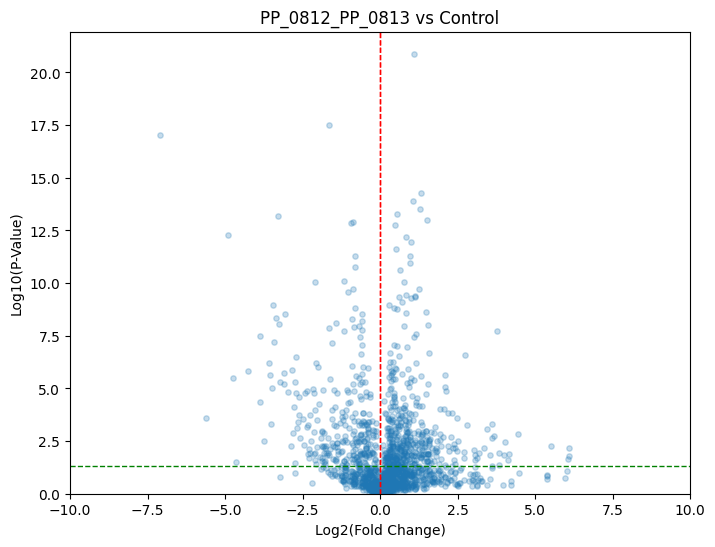

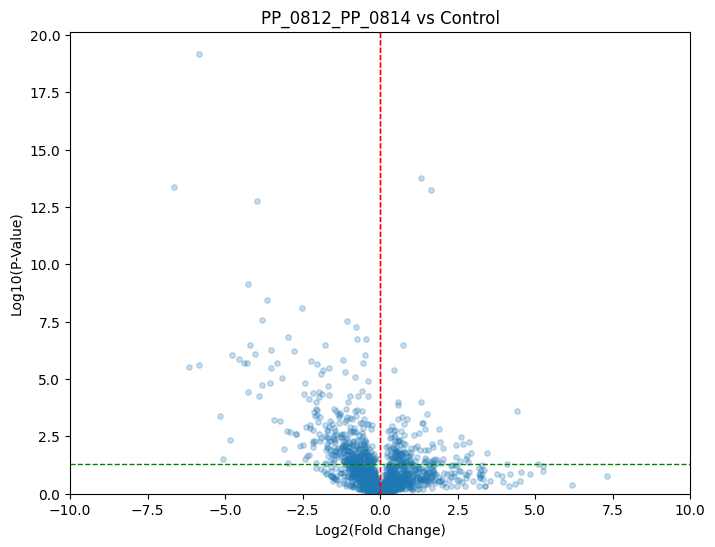

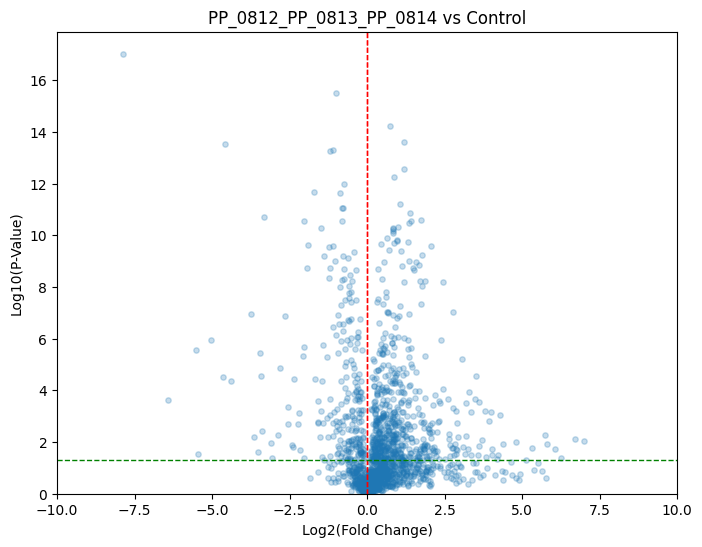

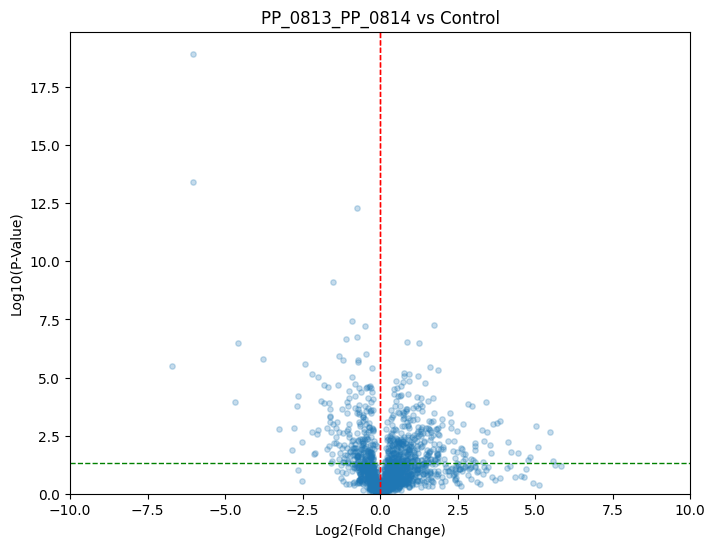

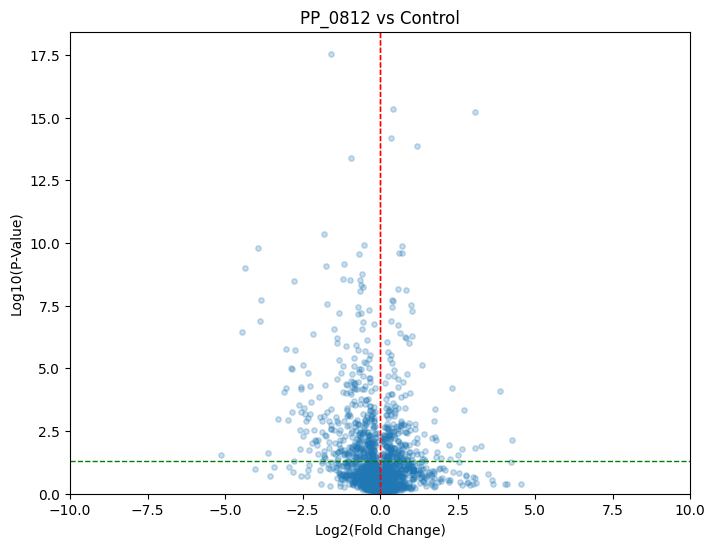

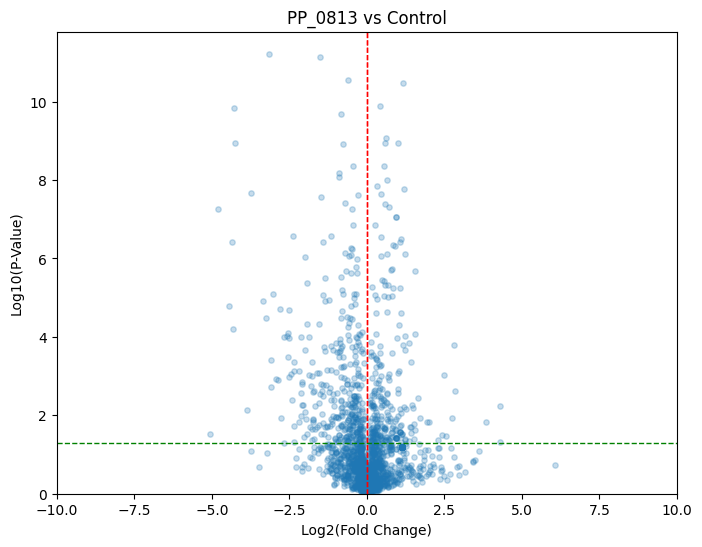

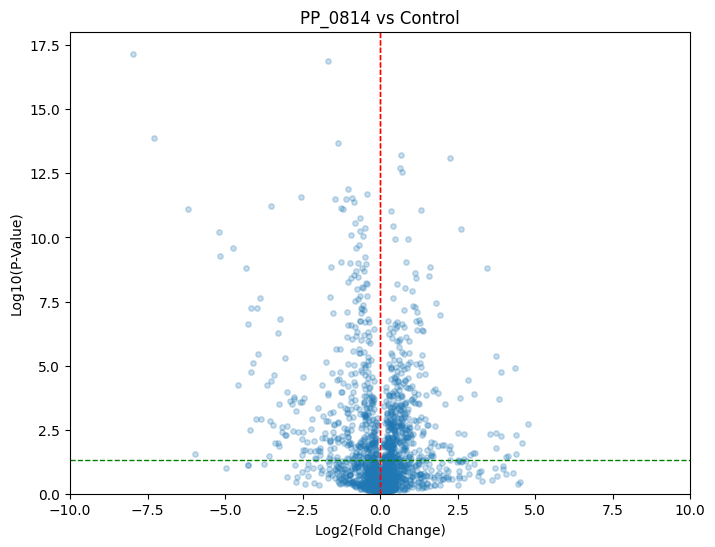

In [8]:
replicates_to_include = ['R4', 'R5', 'R6']
for sample, control in sample_control_pairs.items():
    # Filter data for the current sample and its control
    if sample in ['PP_0812', 'PP_0813']:
        sample_data = combined_df[(combined_df['Sample'] == sample) & (combined_df['Replicate'].isin(replicates_to_include))]
    else:
        sample_data = combined_df[combined_df['Sample'] == sample]
    
    control_data = combined_df[combined_df['Sample'] == control]

    # Debug: Check if data is loaded correctly
    if sample_data.empty or control_data.empty:
        print(f"No data for {sample} or {control}")
        continue

    # Compute mean %_of protein_abundance_Top3-method for each protein
    sample_mean = sample_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()
    control_mean = control_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()

    # Rename columns for clarity
    sample_mean.rename(columns={'%_of protein_abundance_Top3-method': 'sample_abundance'}, inplace=True)
    control_mean.rename(columns={'%_of protein_abundance_Top3-method': 'control_abundance'}, inplace=True)

    # Merge the data on Protein.Group
    merged_data = pd.merge(sample_mean, control_mean, on='Protein.Group', how='outer')

    # Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['sample_abundance'] / merged_data['control_abundance'])

    # Debug: Check if log2_change contains NaN values
    if merged_data['log2_change'].isna().all():
        print(f"All log2 fold changes are NaN for {sample} vs {control}")
        continue

    # Compute p-values (assume replicates data exists for actual p-value calculation)
    sample_reps = sample_data[['Protein.Group', '%_of protein_abundance_Top3-method']]
    control_reps = control_data[['Protein.Group', '%_of protein_abundance_Top3-method']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = sample_reps[sample_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        group2 = control_reps[control_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Debug: Check if log10_p_value contains NaN values
    if merged_data['log10_p_value'].isna().all():
        print(f"All log10 p-values are NaN for {sample} vs {control}")
        continue

    # Filter based on plotting criteria
    filtered_data = merged_data[
        (merged_data['log2_change'].abs() > log2_fold_change_threshold) &
        (merged_data['log10_p_value'] > -np.log10(p_value_threshold))
    ]

    # Store filtered results in log2_log10_results
    if log2_log10_results.empty:
        log2_log10_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        log2_log10_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
    else:
        temp_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        temp_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
        log2_log10_results = pd.merge(
            log2_log10_results,
            temp_results,
            left_on='Protein.Group',
            right_on='Protein.Group',
            how='outer'
        )

#     # Create volcano plot for the current sample
#     fold_change = merged_data['log2_change']
#     p_values = merged_data['log10_p_value']

#     plt.figure(figsize=(8, 6))
#     plt.scatter(fold_change, p_values, s=15, alpha=0.25)
#     plt.title(f"{sample} vs {control}")
#     plt.xlabel("Log2(Fold Change)")
#     plt.ylabel("Log10(P-Value)")
#     plt.grid(False)
#     plt.ylim(0,)
#     plt.xlim(-10, 10)

#     # Threshold lines
#     plt.axvline(x=log2_fold_change_threshold, color='r', linestyle='--', linewidth=1)
#     plt.axvline(x=-log2_fold_change_threshold, color='r', linestyle='--', linewidth=1)
#     plt.axhline(y=-np.log10(p_value_threshold), color='g', linestyle='--', linewidth=1)

#     # Annotate significant points; this adds arrows to each of the plots and is computationally intensive, will probably crash if threshold zero
# #     texts = []
# #     labels = merged_data['Protein.Group']
# #     for i, label in enumerate(labels):
# #         if (fold_change[i] > log2_fold_change_threshold or fold_change[i] <-log2_fold_change_threshold) and p_values[i] > -np.log10(p_value_threshold):
# #             text = plt.text(fold_change[i], p_values[i], label, fontsize=10)
# #             texts.append(text)

# #     if texts:
# #         adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

#     # Show the plot
#     # plt.show()

# Save the filtered log2 and log10 values to a CSV file
log2_log10_results.to_csv('No_Top3_Filter_log2_log10_values_by_significance.csv', index=False)
print("Filtered Log2 and Log10 values saved to 'filtered_log2_log10_values_by_significance.csv'")

Filtered for %_of protein_abundance_Top3-method <0.01

In [18]:
# DataFrames to store results
log2_log10_results = pd.DataFrame()
raw_abundance_results = pd.DataFrame()

replicates_to_include = ['R4', 'R5', 'R6']
for sample, control in sample_control_pairs.items():
    # Filter data for the current sample and its control
    if sample in ['PP_0812', 'PP_0813']:
        sample_data = combined_df[(combined_df['Sample'] == sample) & (combined_df['Replicate'].isin(replicates_to_include))]
    else:
        sample_data = combined_df[combined_df['Sample'] == sample]
    
    control_data = combined_df[combined_df['Sample'] == control]

    # Debug: Check if data is loaded correctly
    if sample_data.empty or control_data.empty:
        print(f"No data for {sample} or {control}")
        continue

    # Compute mean %_of protein_abundance_Top3-method for each protein
    sample_mean = sample_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()
    control_mean = control_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()
    
    # Rename columns for clarity
    sample_mean.rename(columns={'%_of protein_abundance_Top3-method': 'sample_abundance'}, inplace=True)
    control_mean.rename(columns={'%_of protein_abundance_Top3-method': 'control_abundance'}, inplace=True)

    # Filter sample_mean to include only abundances > 0.001
    sample_mean = sample_mean[sample_mean['sample_abundance'] > 0.01]

    # Merge the data on Protein.Group
    merged_data = pd.merge(sample_mean, control_mean, on='Protein.Group', how='outer')

    # Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['sample_abundance'] / merged_data['control_abundance'])

    # Debug: Check if log2_change contains NaN values
    if merged_data['log2_change'].isna().all():
        print(f"All log2 fold changes are NaN for {sample} vs {control}")
        continue

    # Compute p-values (assume replicates data exists for actual p-value calculation)
    sample_reps = sample_data[['Protein.Group', '%_of protein_abundance_Top3-method']]
    control_reps = control_data[['Protein.Group', '%_of protein_abundance_Top3-method']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = sample_reps[sample_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        group2 = control_reps[control_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Debug: Check if log10_p_value contains NaN values
    if merged_data['log10_p_value'].isna().all():
        print(f"All log10 p-values are NaN for {sample} vs {control}")
        continue

    # Filter based on plotting criteria
    filtered_data = merged_data[
        (merged_data['log2_change'].abs() > log2_fold_change_threshold) &
        (merged_data['log10_p_value'] > -np.log10(p_value_threshold))
    ]

    
    # Store filtered results in log2_log10_results
    if log2_log10_results.empty:
        log2_log10_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        log2_log10_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
    else:
        temp_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        temp_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )
        log2_log10_results = pd.merge(
            log2_log10_results,
            temp_results,
            left_on='Protein.Group',
            right_on='Protein.Group',
            how='outer'
        )

# Save the filtered log2 and log10 values to a CSV file
log2_log10_results.to_csv('Test.csv', index=False)
print("Filtered Log2 and Log10 values saved to 'Test.csv'")


Filtered Log2 and Log10 values saved to 'Test.csv'


### Investigating genes that are upregulated amongst a subset of samples

#### TCA Cycle

In [8]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-TCA.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

# Filter the data to include only the proteins that are significant for all samples of interest
filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])

# Compare the filtered data against the second list of proteins
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the TCA cycle were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

4 out of 21 genes in the TCA cycle were significantly changed across strains
Those genes were:
Gene Accession Gene name                  Enzymatic activity  PP_0812_PP_0813_log2_FC  PP_0812_PP_0814_log2_FC  PP_0812_PP_0813_PP_0814_log2_FC  PP_0813_PP_0814_log2_FC  PP_0812_log2_FC  PP_0813_log2_FC  PP_0814_log2_FC  PP_0812_PP_0813_log10_pval  PP_0812_PP_0814_log10_pval  PP_0812_PP_0813_PP_0814_log10_pval  PP_0813_PP_0814_log10_pval  PP_0812_log10_pval  PP_0813_log10_pval  PP_0814_log10_pval
       PP_4185      sucD             succinyl-CoA synthetase                -1.496664                -1.659155                        -1.500778                -1.178474        -1.191672        -1.173949        -1.186829                    3.264188                    5.467839                            3.184765                    5.737112            8.580141            2.400593           11.126186
       PP_4186      sucC             succinyl-CoA synthetase                -1.634635                -1.1

#### Branched Chain AA Superpathway

In [9]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-BRANCHED-CHAIN-AA-SYN-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])

# Compare the filtered data against the second list of proteins
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the AA superpathway were significantly changed across strains")
# Merge the matching proteins with the proteins_txt DataFrame to get additional information
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
# Include columns for p-values and fold changes for the samples of interest
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')


# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

3 out of 16 genes in the AA superpathway were significantly changed across strains
Those genes were:
Gene Accession Gene name          Enzymatic activity  PP_0812_PP_0813_log2_FC  PP_0812_PP_0814_log2_FC  PP_0812_PP_0813_PP_0814_log2_FC  PP_0813_PP_0814_log2_FC  PP_0812_log2_FC  PP_0813_log2_FC  PP_0814_log2_FC  PP_0812_PP_0813_log10_pval  PP_0812_PP_0814_log10_pval  PP_0812_PP_0813_PP_0814_log10_pval  PP_0813_PP_0814_log10_pval  PP_0812_log10_pval  PP_0813_log10_pval  PP_0814_log10_pval
       PP_4678      ilvC ketol-acid reductoisomerase                -0.804492                -0.521761                        -0.932173                -0.534823        -0.536482        -0.470665        -0.807656                   10.783496                    3.246414                            5.445061                    3.304177            8.259816            2.216019           10.555034
       PP_4679      ilvH       acetolactate synthase                -0.808471                -1.134209             

#### Glycolysis Genes

In [10]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-PWY1G01-2.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total
print(f"{included} out of {total} genes in glycolysis were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

2 out of 34 genes in glycolysis were significantly changed across strains
Those genes were:
Gene Accession Gene name                       Enzymatic activity  PP_0812_PP_0813_log2_FC  PP_0812_PP_0814_log2_FC  PP_0812_PP_0813_PP_0814_log2_FC  PP_0813_PP_0814_log2_FC  PP_0812_log2_FC  PP_0813_log2_FC  PP_0814_log2_FC  PP_0812_PP_0813_log10_pval  PP_0812_PP_0814_log10_pval  PP_0812_PP_0813_PP_0814_log10_pval  PP_0813_PP_0814_log10_pval  PP_0812_log10_pval  PP_0813_log10_pval  PP_0814_log10_pval
       PP_2149      gapB glyceraldehyde-3-phosphate dehydrogenase                  0.60906                 0.639343                         0.748968                 0.604586         0.569588         0.591486         0.694460                    3.095931                    2.345638                            2.914755                    2.179789            1.604165            1.367854           12.554646
       PP_3378      kguK                      2-ketogluconokinase                 -0.48856        

#### Non-oxidative PP Pathway

In [11]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-NONOXIPENT-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

0 out of 4 genes were significantly changed across strains
Those genes were:
Empty DataFrame
Columns: [Gene Accession, Gene name, Enzymatic activity, PP_0812_PP_0813_log2_FC, PP_0812_PP_0814_log2_FC, PP_0812_PP_0813_PP_0814_log2_FC, PP_0813_PP_0814_log2_FC, PP_0812_log2_FC, PP_0813_log2_FC, PP_0814_log2_FC, PP_0812_PP_0813_log10_pval, PP_0812_PP_0814_log10_pval, PP_0812_PP_0813_PP_0814_log10_pval, PP_0813_PP_0814_log10_pval, PP_0812_log10_pval, PP_0813_log10_pval, PP_0814_log10_pval]
Index: []


#### Oxidative PP Pathway

In [12]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-OXIDATIVEPENT-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

0 out of 5 genes were significantly changed across strains
Those genes were:
Empty DataFrame
Columns: [Gene Accession, Gene name, Enzymatic activity, PP_0812_PP_0813_log2_FC, PP_0812_PP_0814_log2_FC, PP_0812_PP_0813_PP_0814_log2_FC, PP_0813_PP_0814_log2_FC, PP_0812_log2_FC, PP_0813_log2_FC, PP_0814_log2_FC, PP_0812_PP_0813_log10_pval, PP_0812_PP_0814_log10_pval, PP_0812_PP_0813_PP_0814_log10_pval, PP_0813_PP_0814_log10_pval, PP_0812_log10_pval, PP_0813_log10_pval, PP_0814_log10_pval]
Index: []


#### PP Pathway

In [13]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-PENTOSE-P-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

0 out of 9 genes were significantly changed across strains
Those genes were:
Empty DataFrame
Columns: [Gene Accession, Gene name, Enzymatic activity, PP_0812_PP_0813_log2_FC, PP_0812_PP_0814_log2_FC, PP_0812_PP_0813_PP_0814_log2_FC, PP_0813_PP_0814_log2_FC, PP_0812_log2_FC, PP_0813_log2_FC, PP_0814_log2_FC, PP_0812_PP_0813_log10_pval, PP_0812_PP_0814_log10_pval, PP_0812_PP_0813_PP_0814_log10_pval, PP_0813_PP_0814_log10_pval, PP_0812_log10_pval, PP_0813_log10_pval, PP_0814_log10_pval]
Index: []


#### Oxidative Phosphorylation

In [14]:
# Define the second list of proteins
proteins_txt = pd.read_csv('pathway-genes-PWY-Respiration_Pooled.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt2 = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt2['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

5 out of 32 genes were significantly changed across strains
Those genes were:
Gene Accession Gene name                           Enzymatic activity  PP_0812_PP_0813_log2_FC  PP_0812_PP_0814_log2_FC  PP_0812_PP_0813_PP_0814_log2_FC  PP_0813_PP_0814_log2_FC  PP_0812_log2_FC  PP_0813_log2_FC  PP_0814_log2_FC  PP_0812_PP_0813_log10_pval  PP_0812_PP_0814_log10_pval  PP_0812_PP_0813_PP_0814_log10_pval  PP_0813_PP_0814_log10_pval  PP_0812_log10_pval  PP_0813_log10_pval  PP_0814_log10_pval
       PP_0812      cyoA              cytochrome bo3 terminal oxidase                -3.276750                -6.655575                        -4.579407                -6.027537        -3.020403        -3.159749        -3.525573                   13.169411                   13.368554                           13.541984                   13.397527            5.789092           11.220289           11.217812
       PP_0813      cyoB              cytochrome bo3 terminal oxidase                -7.082125          

In [15]:
# Define the second list of proteins
proteins_txt = pd.read_csv('glutamine_glutamate.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt2 = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt2['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv('matching_proteins.csv', index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

0 out of 19 genes were significantly changed across strains
Those genes were:
Empty DataFrame
Columns: [Gene Accession, Gene name, Enzymatic activity, PP_0812_PP_0813_log2_FC, PP_0812_PP_0814_log2_FC, PP_0812_PP_0813_PP_0814_log2_FC, PP_0813_PP_0814_log2_FC, PP_0812_log2_FC, PP_0813_log2_FC, PP_0814_log2_FC, PP_0812_PP_0813_log10_pval, PP_0812_PP_0814_log10_pval, PP_0812_PP_0813_PP_0814_log10_pval, PP_0813_PP_0814_log10_pval, PP_0812_log10_pval, PP_0813_log10_pval, PP_0814_log10_pval]
Index: []
The genes were saved to 'locus_genes.csv'
